# Mid Term Project
by:
Srinivasan Narayanan
and
Denny Meyer

<a id='content'></a>
### Table of content

<a href='#introduction'> 1. Introduction</a>
- motivation
- data set King County
- questions

<a href='#setup'>2. Setup libraries</a>

- pandas, numpy
- sklearn

    <a href='#helper_function'>2.1 Helper functions</a>
    - loading data table
    - plot data

    <a href='#data_functions'>2.2 Data functions</a>
    - interquartile range
    - remove series
    - create dummie table for categorizing
    - aggregate transformation

    <a href='#model_functions'>2.3 Model functions</a>
    - linear regression model with sklearn library
    - linear regression model with statsmodel api -> printing model results
    - validate model

<a href='#raw_data'>3. Review raw data</a>

- loading raw data

    <a href='#plot_raw'> 3.1 Plot raw data</a>

    <a href='#heatmap'> 3.2 Heatmap</a>

    <a href='#analyze_raw_data'> 3.3 Discuss Raw Data</a>

[4. Modeling]()
- [4.1 Version 1 model with nearly raw data](#version_1)
    - using raw data

- [4.2 Version 2 model limited input](#version_2)

    - interquatile usage Bedrooms

- [4.3 Version 3 model limited input](#version_3)

    - interquartile bedrooms
    - apply transformation 'boc-cox' 

- [4.4 Version 4 categorizing zipcode](#version_4) 
    - interquartile bedrooms
    - categorizing zipcode, grade, bedrooms

<a href='#plot_regression'>plot regression graph</a>

<a href='#final_notes'>6. final notes</a>

<a id='introduction'></a>
### 1. Introduction
[back to content list](#content)

<a href='#content'>back to content list</a>
<a id='setup'></a> 
### 2. Setup

In [1]:
# import libraries

# dealing with data libs
import pandas as pd
import numpy as np
 

# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm # progressbar for looping


# machine learning libs
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer, MinMaxScaler,RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import statsmodels.api as sm



<a href='#content'>back to content list</a>
<a id='helper_function'></a> 
#### 2.1 Helper Functions

In [2]:
# ploting all numerical data from dataframe

def plot_numeric(data):
    for i in data._get_numeric_data():
        fig , ax = plt.subplots(1,2, figsize=(15,7))
        plt.title(i)
        sns.boxplot(x=data[i], ax=ax[0])
        sns.histplot(data[i], ax=ax[1])

        plt.show()

In [3]:
# ploting only on specific series

def plot_numeric_part(data: pd.DataFrame, name: str):
    plot_data = data[name]
    fig , ax = plt.subplots(1,2, figsize=(15,7))
    plt.title(name)
    sns.boxplot(x=plot_data, ax=ax[0])
    sns.histplot(plot_data, ax=ax[1])

    plt.show()

#### plot function

In [4]:
# Make an scatter plot y_pred vs y
# What kind of plot you will get if all the all the predictions are ok?
# A stright line

def plot_train_vs_test(y_pred_train, y_pred_test, y_test, y_train):
    result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    fig, ax = plt.subplots(2,3,figsize=(18,10))
    ax[0,0].plot(y_pred_test, y_test, 'o',color='red')
    ax[0,0].set_xlabel("y_test")
    ax[0,0].set_ylabel("y_pred")
    ax[0,0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[0,1].hist(y_test - y_pred_test, color='red')
    ax[0,1].set_xlabel("Test y-y_pred")
    ax[0,1].set_title("Test Set Residual histogram")

    ax[0,2].plot(y_pred_test,y_test - y_pred_test,"o", color='red')
    ax[0,2].set_xlabel("predited")
    ax[0,2].set_ylabel("residuals")
    ax[0,2].set_title("Residuals by Predicted")
    ax[0,2].plot(y_pred_test,np.zeros(len(y_pred_test)),linestyle='dashed')



    ax[1,0].plot(y_pred_train, y_train, 'o')
    ax[1,0].set_xlabel("y_train")
    ax[1,0].set_ylabel("y_pred_train")
    ax[1,0].set_title("Train set Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1,1].hist(y_train - y_pred_train)
    ax[1,1].set_xlabel("Train y-y_pred")
    ax[1,1].set_title("Train Residual histogram")

    ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
    ax[1,2].set_xlabel("predited")
    ax[1,2].set_ylabel("residuals")
    ax[1,2].set_title("Residuals by Predicted -- Train set")
    ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')
    

<a id='data_functions'></a>
<a href='#content'>back to content list</a>
#### 2.2 Functions for optional data handling:

#### option 1 Interquartile

In [5]:
# rip data in interquartile range

def reduce_to_interquartile(data: pd.DataFrame, name: list) -> pd.DataFrame:
    Q1 = data[name].quantile(0.25)
    Q3 = data[name].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (data[name] >= Q1 - 1.5 * IQR) & (data[name] <= Q3 + 1.5 *IQR)
    data=data.loc[filter] 

    return data

#### option 2 remove

In [6]:
# remove column

def remove_column(data: pd.DataFrame, name: list) -> pd.DataFrame:
    data = data.drop(columns=name, inplace= True)

    return data

#### create dummy table for categorie

In [7]:
def create_dummies_for_categorie(data, name):
    data = pd.get_dummies(data, columns=[name], drop_first = True)
    return data

#### perform transformation operation on data

In [8]:
# transform operation

# input:
# - data: as panda datafram
# - name: column name where transformation should apply
# - operator: string value which operator should used -> pwr: PowerTransform, minmax: MinMaxTransform, robust: RobustTransform
# - lambda: if transformation can use a lambda value, otherwise 0 as default

# return:
# panda dataframe

pwr = PowerTransformer()
robust = RobustScaler()
minMax = MinMaxScaler()

def aggregate_transform(data: pd.DataFrame, name: str, operator: str = 'pwr', lamda_value: float = 0)-> pd.DataFrame:
    transformer = pwr

    if operator == 'pwr':
        transformer = pwr
    elif operator == 'minmax':
        transformer = minMax
    elif operator == 'robust':
        transformer = robust
    if lamda_value != 0:
        transformer.lambdas_ = lamda_value
    data[name] = transformer.fit_transform(data[name].to_numpy().reshape(-1,1))
    return data


#### apply scaler on given dataset

In [9]:
# takes train and test data as input, apply standart scaler fitted on traindata and return both datasets

def apply_standart_scaler(x_train_data: pd.DataFrame, x_test_data: pd.DataFrame):
    scaler_train = StandardScaler().fit(x_train_data)
    scaler_train.transform(x_train_data)
    scaler_train.transform(x_test_data)
    return x_train_data, x_test_data

<a id='model_functions'></a>
<a href='#content'>back to content list</a>
#### 2.3 Model functions

In [10]:
# create linear regression model using sklearn library
# this one is heavily used during the whole process

def create_linear_model(x_train: pd.DataFrame, y_train: pd.DataFrame) -> LinearRegression:
    model_l = LinearRegression()
    model_l.fit(x_train, y_train)

    return model_l

In [11]:
# create linear regression model using statsmodel api
# this one is mainly used for presenting r2 and score values for used input values
# as it´s summary function offers a pretty handy way for displaying the results

def create_linear_model_statsmodel_analyze(x_train: pd.DataFrame, y_train: pd.DataFrame):
    x_train_sm = sm.add_constant(x_train) # adding a constant
    model = sm.OLS(list(y_train), x_train_sm).fit()

    return model.summary() # just print the summary as table 


#### validate results

In [12]:
# plot an usefull summary of all redual values in comperison test and train predictions
# as well most significant features


def validate_results( model, x_train, y_train, y_test, y_pred_train, y_pred_test):

    result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_test})

    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    plot_train_vs_test(y_pred_train, y_pred_test, y_test, y_train)
    
    features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model.coef_)})

    #
    # this option is highly used in the last case to packing all attributes 
    # with similar attributes names together and represent this as one feature with respect to the mean value
    # of this attribute
    #
    # seperate features
    zip_mean = features_importances[features_importances['Attribute'].str.startswith('zip') == True]
    grade_mean = features_importances[features_importances['Attribute'].str.startswith('grade') == True]
    floors_mean = features_importances[features_importances['Attribute'].str.startswith('floor') == True]
    condition_mean = features_importances[features_importances['Attribute'].str.startswith('condition') == True]
    bedrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bedroom') == True]
    bathrooms_mean = features_importances[features_importances['Attribute'].str.startswith('bathrooms') == True]

    # drop this features from table
    features_importances = features_importances[features_importances['Attribute'].str.startswith('zip') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('grade') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('floor') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('condition') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('bedroom') != True]
    features_importances = features_importances[features_importances['Attribute'].str.startswith('bathrooms') != True]


    # add packed features with mean value to the feature list
    features_importances.loc[features_importances.index.max() + 1] = ['grade', grade_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['zipcode', zip_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['floors', floors_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['condition', condition_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['bedrooms', bedrooms_mean['Importance'].values.mean()]
    features_importances.loc[features_importances.index.max() + 1] = ['bathrooms', bathrooms_mean['Importance'].values.mean()]


    # please sort
    features_importances = features_importances.sort_values(by='Importance', ascending=False)
    


    fig, ax = plt.subplots(figsize=(20,10))
    sns.barplot(x=features_importances['Attribute'], y=features_importances['Importance'])

    plt.show()
    
    print('Most important features:')
    print(features_importances)

    train_mse=mse(y_train,y_pred_train)
    test_mse=mse(y_test,y_pred_test)

    print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

    print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

    train_mae=mae(y_train,y_pred_train)
    test_mae=mae(y_test,y_pred_test)

    print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

    R2_train=r2_score(y_train,y_pred_train)
    R2_test=r2_score(y_test,y_pred_test)

    print('r2 train:',R2_train)
    print('r2 test:',R2_test)
    

### load raw data
<a id='raw_data'></a>
<a href='#content'>back to content list</a>


In [13]:
# load data and create work_copy

raw_data = pd.read_excel('../data/Data_MidTerm_Project_Real_State_Regression.xls')


### 3. Review data
<a href='#content'>back to content list</a>

In [14]:
raw_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,2014-10-13,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,2014-12-09,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2015-02-25,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,2014-12-09,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2015-02-18,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id='plot_raw'></a>
<a href='#content'>back to content list</a>
### Plotting raw data

In [15]:
# analyze raw data
#plot_numeric(raw_data)


#### 3.2 Heatmap
<a id='heatmap'></a>
<a href='#content'>back to content list</a>

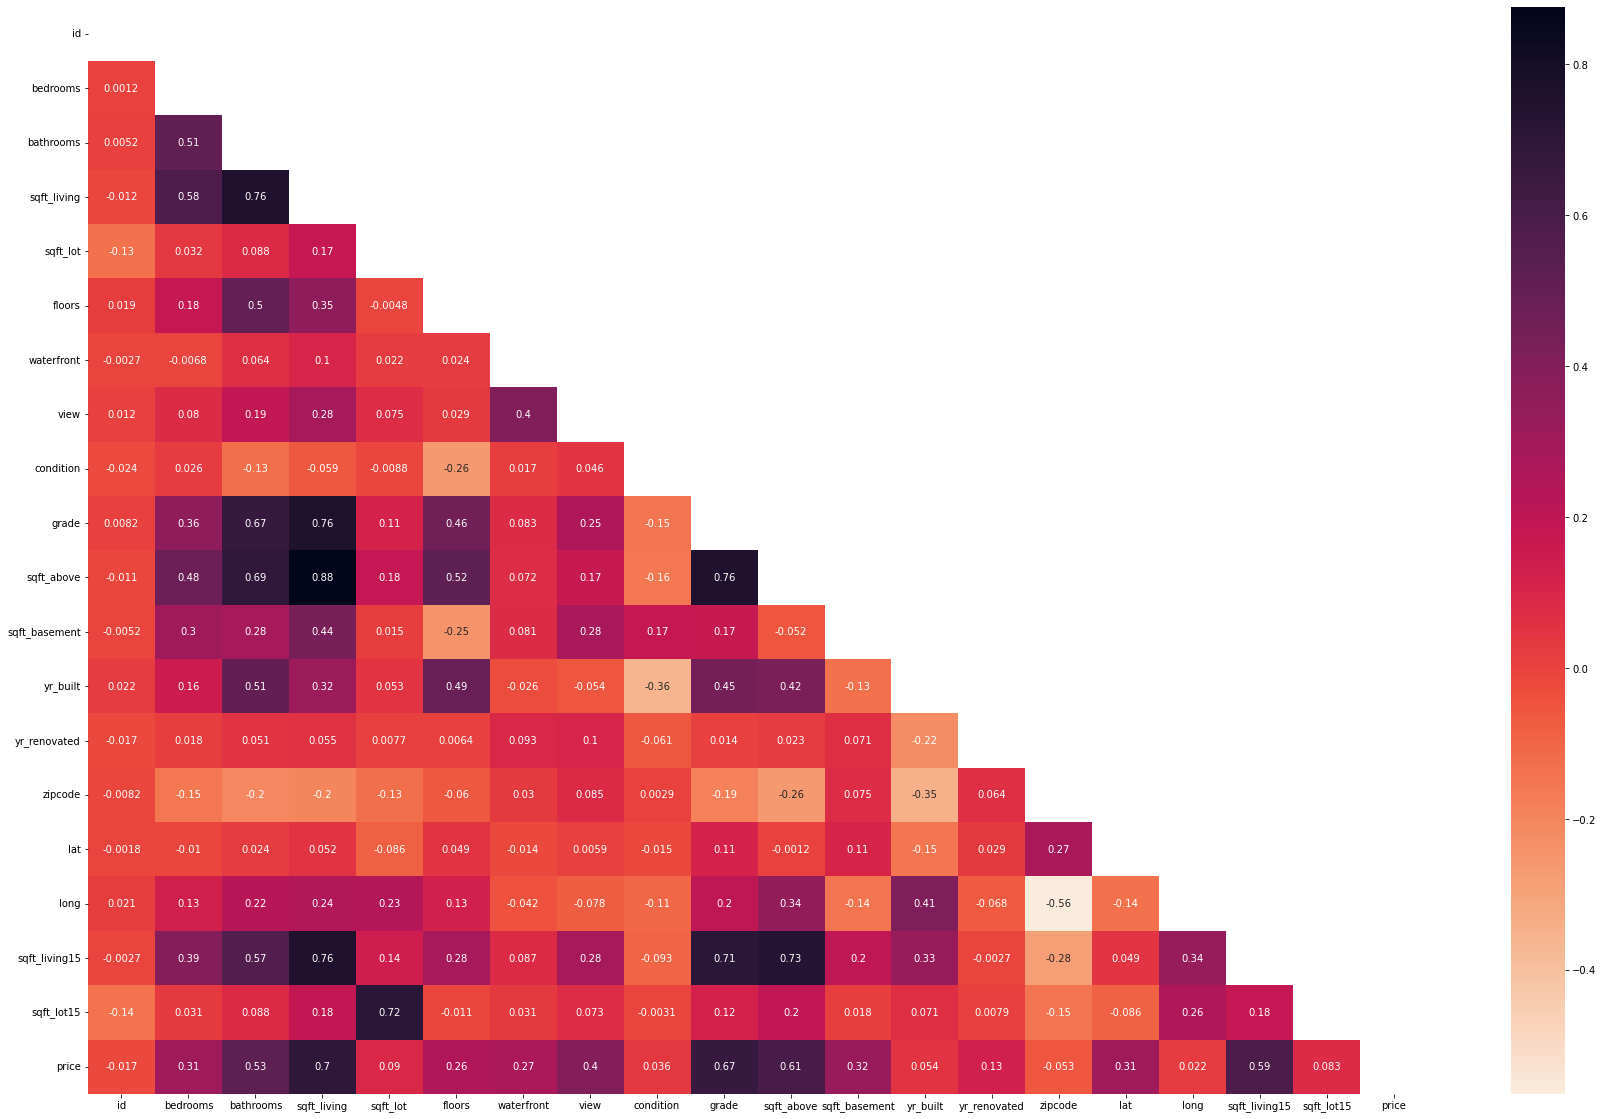

In [16]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(raw_data._get_numeric_data().corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(30, 20))
ax=sns.heatmap(raw_data._get_numeric_data().corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

<a id='analyze_raw_data'></a>
<a href='#content'>back to content list</a>
### **Discussion raw data:** 

> id -> will be removed as not mandatory
>
> bedrooms -> need adjustments as max 33 could be an outlayer, without -> normal distributed
>
> bathrooms -> max 8 needs to check, if its fits with connected sqft range ->
>
> sqft_living -> maybe recalculated in square meter to fit better in european perspective
>
> sqft_lot -> similar to sqft_living
>
> floors -> maybe changable to ordonal categorical
>
> waterfront -> set to categorical 
>
> view -> needs review why min to 75% is zero with an max of 4
>
> condition -> transform to ordonal categorical 0-5
>
> grade -> as descripted typical ordonal categorical 0-13
>
> sqft_above -> similar to sqft_living
>
> sqft_basement -> similar to sqft_living
> - as sqft_basement looks without zero numbers as normal distributed
> - ***ToDo:*** drop zero values from this column
> - create category 'has_basement'
> - fill all 'has_basement' where basement is included
>
> yr_build -> use as number or could be ordonal category when binning with steps e.g 5 years 1900-1905 ....
>
> zip code, lat and long -> skipt or could binning or clustered to regions 
>
> sqft_living15 and sqft_lot15 represents the average living and lot sqft of the closest 15 neiboorhouses





<a id='version_1'></a>
### Version 1
<a href='#content'>back to content list</a>


This example using nearly the whole data set to get a first impression.

Only ID and Date will dropped as ID holds no usefull information

The Date can not used without further transformation

In [17]:
# drop first not need data
work_copy_v1= raw_data.copy()

work_copy_v1.drop(columns=['id', 'date'], inplace=True)


In [18]:
# drop label or dependent value for ML
label_v1 = work_copy_v1['price']
work_copy_v1.drop(columns='price', inplace=True)


In [19]:
# split dataset in 80% training data and hold 20% for evaluating the results

x_train_v1, x_test_v1, y_train_v1, y_test_v1 = train_test_split(work_copy_v1, label_v1, test_size=0.2, random_state=42)

In [20]:
# apply standart scale on train and test data
# Note: the function behind will fit the scaler only with the training data, but apply the resulting scaler in both sets

x_train_v1, x_test_v1 = apply_standart_scaler(x_train_data=x_train_v1, x_test_data=x_test_v1)

In [21]:
# linear model with sklearn 

model_v1 = create_linear_model(x_train=x_train_v1, y_train=y_train_v1)

In [22]:
# just a handy plot to check internal values

create_linear_model_statsmodel_analyze(x_train_v1, y_train_v1)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2392.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:52:52   Log-Likelihood:            -2.3552e+05
No. Observations:               17277   AIC:                         4.711e+05
Df Residuals:                   17259   BIC:                         4.712e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.188e+06   3.28e+06      1.884      0.060   -2.49e+05    1.26e+07
bedrooms      -3.835e+04   2212.127    -17.335      0.000   -4.27e+04    -3.4e+04
bathrooms      4.213e+04   3681.555     11.442      0.000    3.49e+04    4.93e+04
sqft_living     110.6321      2.581     42.869      0.000     105.574     115.691
sqft_lot          0.1037      0.055      1.898      0.058      -0.003       0.211
floors         8383.0996   4031.878      2.079      0.038     480.210    1.63e+04
waterfront     5.789e+05   1.93e+04     29.926      0.000    5.41e+05    6.17e+05
view           5.172e+04   2399.625     21.552      0.000     4.7e+04    5.64e+04
condition      2.863e+04   2633.790     10.870      0.000    2.35e+04    3.38e+04
grade          9.871e+04   2419.834     40.794      0.000     9.4e+04    1.03e+05
sqft_above       69.0376      2.542     27.154      0.000      64.054      74.021
sqft_basement    41.5972      2.976     13.978      0.000      35.764      47.430
yr_built      -2683.4602     81.391    -32.970      0.000   -2842.994   -2523.926
yr_renovated     19.5500      4.106      4.761      0.000      11.502      27.598
zipcode        -562.6960     36.930    -15.237      0.000    -635.082    -490.310
lat              5.9e+05    1.2e+04     48.963      0.000    5.66e+05    6.14e+05
long          -2.088e+05   1.46e+04    -14.276      0.000   -2.37e+05    -1.8e+05
sqft_living15    24.6215      3.890      6.330      0.000      16.997      32.246
sqft_lot15       -0.4517      0.082     -5.515      0.000      -0.612      -0.291
==============================================================================
Omnibus:                    14778.856   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1466590.026
Skew:                           3.606   Prob(JB):                         0.00
Kurtosis:                      47.557   Cond. No.                     1.18e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [23]:
# create predictions

y_pred_train_v1 = model_v1.predict(x_train_v1)
y_pred_test_v1 = model_v1.predict(x_test_v1)

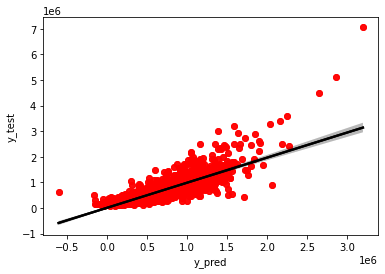

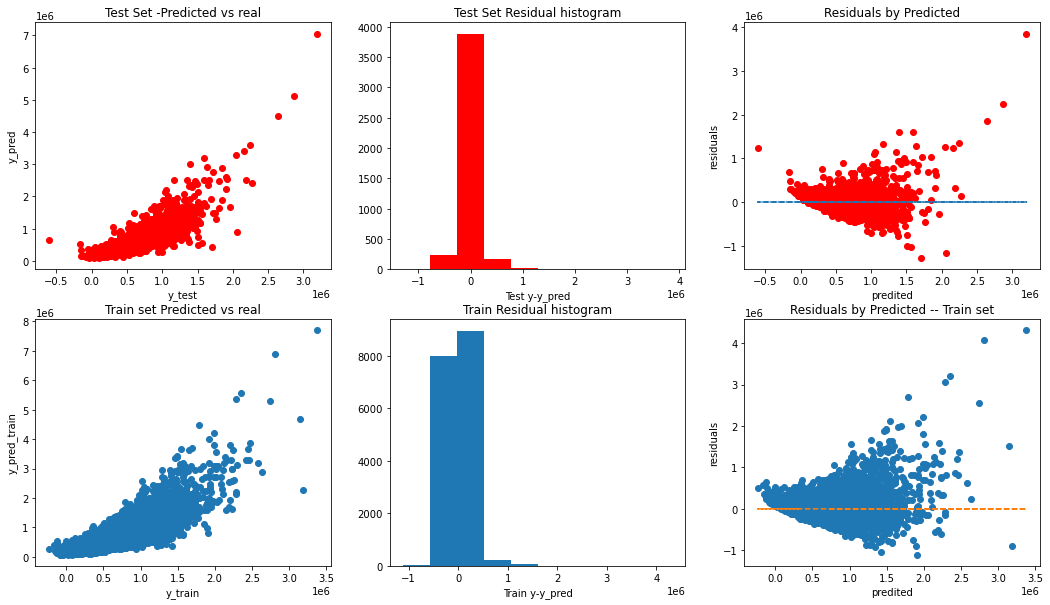

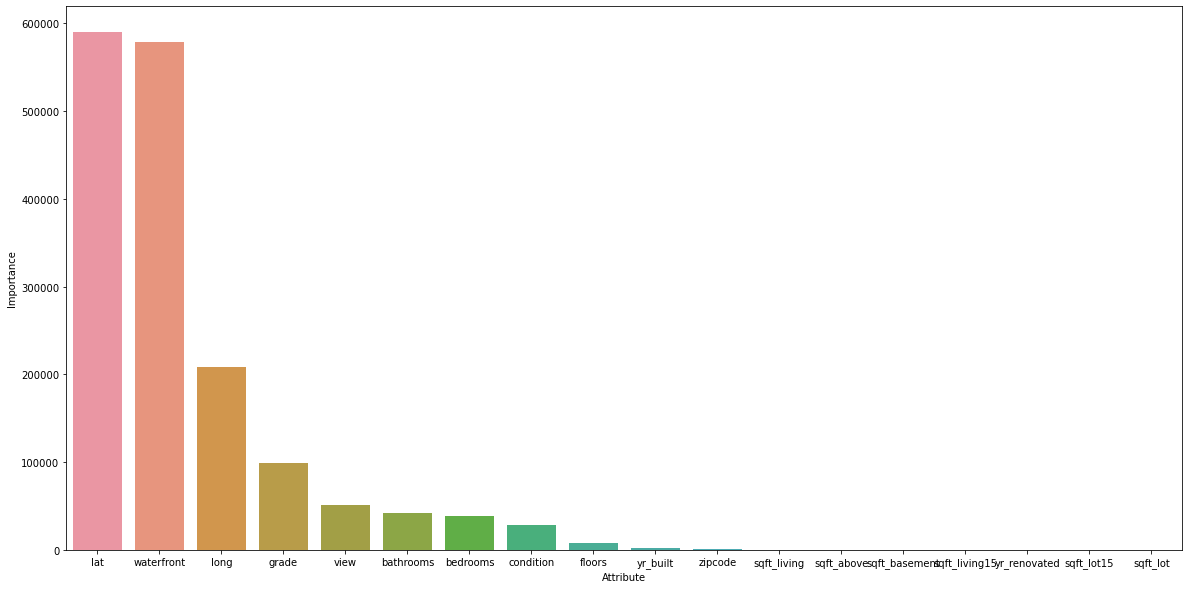

Most important features:
        Attribute     Importance
14            lat  589969.594598
5      waterfront  578940.273893
15           long  208788.216055
18          grade   98713.513694
6            view   51717.326838
23      bathrooms   42125.942503
22       bedrooms   38346.695094
21      condition   28629.833696
20         floors    8383.099561
11       yr_built    2683.460201
19        zipcode     562.695970
2     sqft_living     110.632992
9      sqft_above      69.036713
10  sqft_basement      41.596279
16  sqft_living15      24.621516
12   yr_renovated      19.550010
17     sqft_lot15       0.451728
3        sqft_lot       0.103737
train MSE: 40562876545.17649 -- test MSE: 40182718832.85667
train RMSE: 201402.27542204305 -- test RMSE: 200456.27661127667
train MAE: 40562876545.17649 -- test MAE: 40182718832.85667
r2 train: 0.7020284717016776
r2 test: 0.6914155526646741


In [24]:
# validate results

validate_results(model_v1, x_train_v1, y_train_v1, y_test_v1, y_pred_train_v1, y_pred_test_v1)

### Discussion

First run with an R2 of nearly 0.7 shows that waterfront, grade and location informations are high predictors for this model

- next improvements is clearly review datatypes in terms of outlayers and distribution


<a id='version_2'></a>
### Version 2

[back to content](#content)

In [25]:
# create work copy and drop first not need data
work_copy_v2= raw_data.copy()

work_copy_v2.drop(columns=['id', 'date'], inplace=True)

#### review raw data

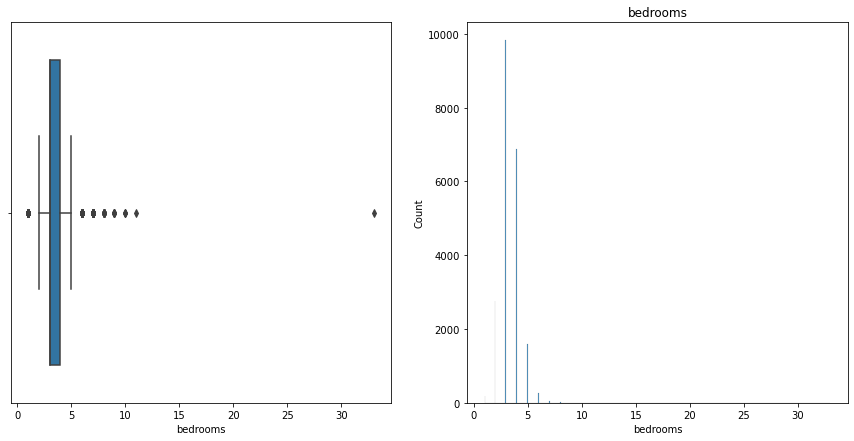

In [26]:
# bedrooms
plot_numeric_part(work_copy_v2, 'bedrooms')

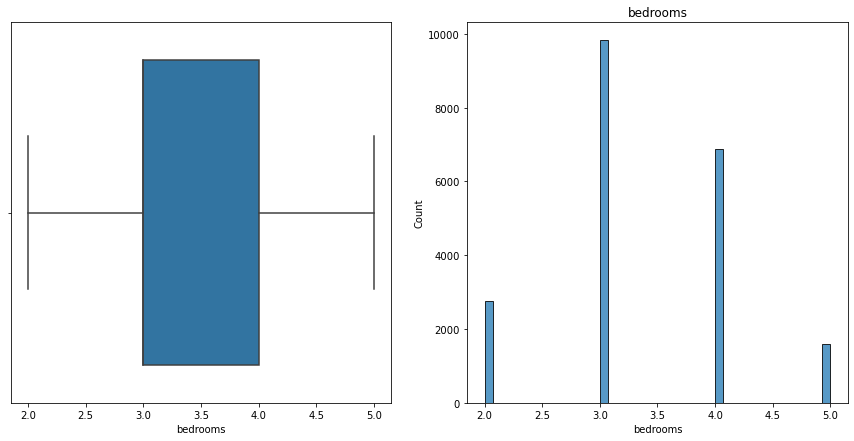

In [27]:
# 33 bedrooms is marked as outlayer and distribution looks like left shifted
# first try aggregate interquartile function

work_copy_v2 = reduce_to_interquartile(work_copy_v2, 'bedrooms')
plot_numeric_part(work_copy_v2, 'bedrooms')

<a id='version_4'></a>
### Version 4 
[back to content list](#content)

In [28]:
work_copy_v4 = raw_data.copy()

In [29]:
# droping long and lat coordinates, as this location information is allready included in the zipcodes
work_copy_v4.drop(columns=['id', 'date', 'long', 'lat', 'sqft_above', 'sqft_lot15', 'sqft_lot'], inplace=True)

In [30]:
# interquartile sqft_living
work_copy_v4 =  work_copy_v4[work_copy_v4['bedrooms'] != 33]
work_copy_v4 = reduce_to_interquartile(data=work_copy_v4, name='bedrooms')

In [31]:
#work_copy = reduce_to_interquartile(data=work_copy, name='price')
transpower = PowerTransformer(method='box-cox')
work_copy_v4['price'] = transpower.fit_transform(work_copy_v4['price'].to_numpy().reshape(-1,1))
work_copy_v4['sqft_living'] = transpower.fit_transform(work_copy_v4['sqft_living'].to_numpy().reshape(-1,1))
work_copy_v4['sqft_living15'] = transpower.fit_transform(work_copy_v4['sqft_living15'].to_numpy().reshape(-1,1))
work_copy_v4['yr_built'] = transpower.fit_transform(work_copy_v4['yr_built'].to_numpy().reshape(-1,1))

In [32]:
# basement has no real influence so i transform this to an binary has or has not field 0 or 1
work_copy_v4['sqft_basement'].values[work_copy_v4['sqft_basement'] != 0] = 1
work_copy_v4['yr_renovated'].values[work_copy_v4['yr_renovated'] != 0] = 1

In [33]:
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'zipcode')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'grade')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'floors')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'bedrooms')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'condition')
work_copy_v4 = create_dummies_for_categorie(work_copy_v4, 'bathrooms')

In [34]:
label_v4 = work_copy_v4['price']
work_copy_v4.drop(columns='price', inplace=True)

In [35]:
x_train_v4, x_test_v4, y_train_v4, y_test_v4 = train_test_split(work_copy_v4, label_v4, test_size= 0.20, random_state= 42)

In [36]:
x_train_v4, x_test_v4 = apply_standart_scaler(x_train_v4, x_test_v4)

In [37]:
model_v4 = create_linear_model(x_train=x_train_v4, y_train=y_train_v4)

In [38]:
y_pred_train_v4 = model_v4.predict(x_train_v4)
y_pred_test_v4 = model_v4.predict(x_test_v4)

In [39]:
create_linear_model_statsmodel_analyze(x_train_v4, y_train_v4)

/opt/anaconda3/envs/DA_Enviroment/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     916.3
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:52:57   Log-Likelihood:                -6736.1
No. Observations:               16853   AIC:                         1.372e+04
Df Residuals:                   16730   BIC:                         1.467e+04
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.2557      0.388     -5.815      0.000      -3.016      -1.495
sqft_living        0.3555      0.007     52.904      0.000       0.342       0.369
waterfront         0.7595      0.036     21.059      0.000       0.689       0.830
view               0.1047      0.004     23.439      0.000       0.096       0.113
sqft_basement     -0.0971      0.008    -12.652      0.000      -0.112      -0.082
yr_built          -0.0126      0.005     -2.294      0.022      -0.023      -0.002
yr_renovated       0.1309      0.015      8.531      0.000       0.101       0.161
sqft_living15      0.1146      0.005     23.307      0.000       0.105       0.124
zipcode_98002     -0.0671      0.037     -1.802      0.072      -0.140       0.006
zipcode_98003      0.0314      0.033      0.951      0.342      -0.033       0.096
zipcode_98004      2.0382      0.032     63.448      0.000       1.975       2.101
zipcode_98005      1.4397      0.040     36.395      0.000       1.362       1.517
zipcode_98006      1.2423      0.029     42.691      0.000       1.185       1.299
zipcode_98007      1.2958      0.042     30.880      0.000       1.214       1.378
zipcode_98008      1.2864      0.033     39.135      0.000       1.222       1.351
zipcode_98010      0.5997      0.046     13.088      0.000       0.510       0.690
zipcode_98011      0.9007      0.037     24.454      0.000       0.829       0.973
zipcode_98014      0.7327      0.043     17.057      0.000       0.649       0.817
zipcode_98019      0.6756      0.037     18.065      0.000       0.602       0.749
zipcode_98022      0.1736      0.035      4.962      0.000       0.105       0.242
zipcode_98023     -0.0849      0.028     -2.991      0.003      -0.141      -0.029
zipcode_98024      1.0414      0.053     19.733      0.000       0.938       1.145
zipcode_98027      1.0576      0.030     35.324      0.000       0.999       1.116
zipcode_98028      0.8290      0.032     25.629      0.000       0.766       0.892
zipcode_98029      1.1683      0.032     36.658      0.000       1.106       1.231
zipcode_98030      0.1018      0.033      3.104      0.002       0.037       0.166
zipcode_98031      0.1380      0.033      4.195      0.000       0.074       0.203
zipcode_98032     -0.0680      0.043     -1.569      0.117      -0.153       0.017
zipcode_98033      1.5114      0.029     51.374      0.000       1.454       1.569
zipcode_98034      1.0997      0.028     39.262      0.000       1.045       1.155
zipcode_98038      0.3504      0.027     12.765      0.000       0.297       0.404
zipcode_98039      2.2176      0.063     35.078      0.000       2.094       2.341
zipcode_98040      1.6321      0.033     48.811      0.000       1.567       1.698
zipcode_98042      0.1479      0.028      5.319      0.000       0.093       0.202
zipcode_9804

<a id='plot_regression'></a>
<a href='#content'>back to content list</a>
### Plot Regression Graph

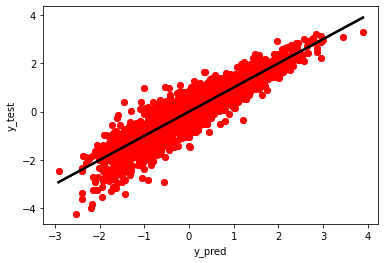

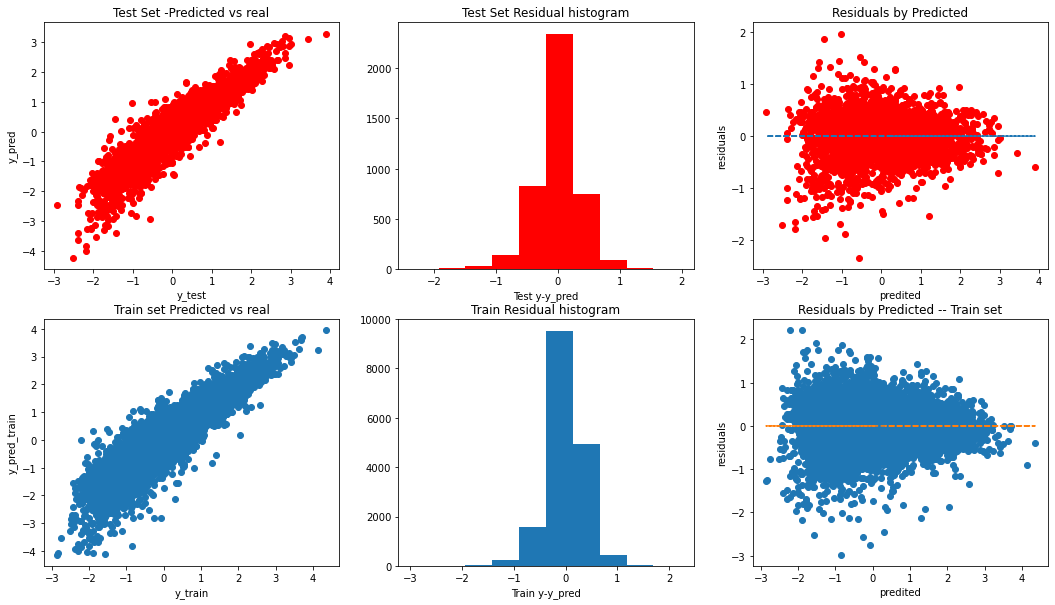

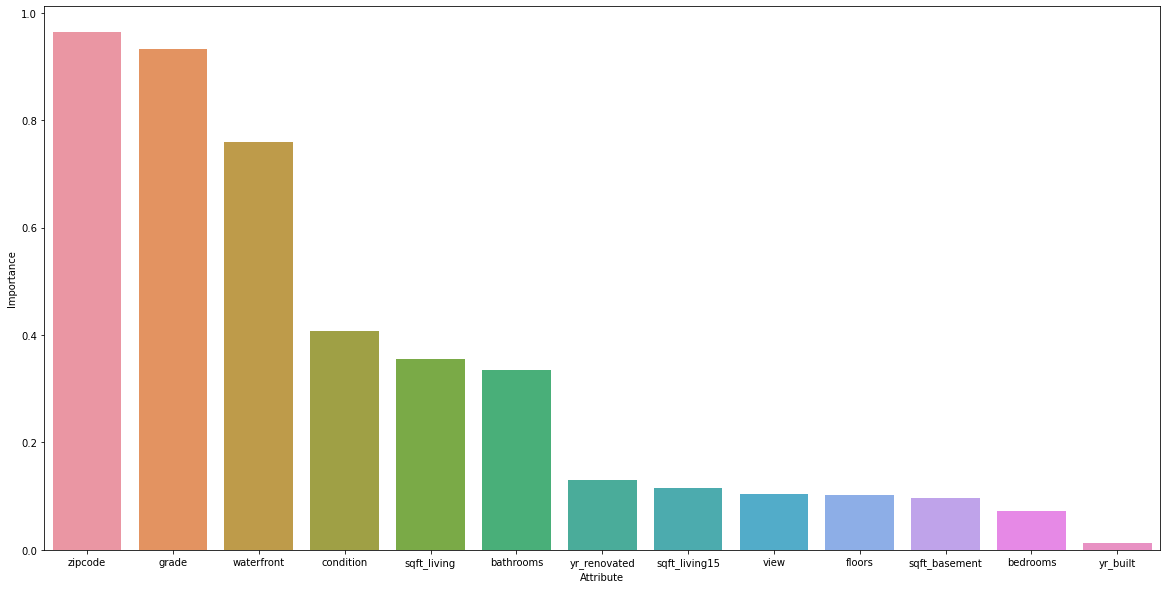

Most important features:
        Attribute  Importance
8         zipcode    0.963569
7           grade    0.932483
1      waterfront    0.759501
10      condition    0.408326
0     sqft_living    0.355540
12      bathrooms    0.334034
5    yr_renovated    0.130894
6   sqft_living15    0.114560
2            view    0.104729
9          floors    0.102975
3   sqft_basement    0.097051
11       bedrooms    0.071763
4        yr_built    0.012606
train MSE: 0.13022564753385257 -- test MSE: 0.13176124321861082
train RMSE: 0.3608679087060147 -- test RMSE: 0.362989315570873
train MAE: 0.13022564753385257 -- test MAE: 0.13176124321861082
r2 train: 0.8698264649163991
r2 test: 0.8680268522795567


In [40]:
validate_results(model_v4, x_train_v4, y_train_v4,y_test_v4,y_pred_train_v4, y_pred_test_v4)

<a id='final_notes'></a>
### 6. Final Notes
<a href='#content'>back to content list</a>